## Download and save gifs

In [1]:
import urllib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
API_KEY = 'bFqX4M742vZ8FxcSzvk7xMMi6EpGCVDq'
N_FILES = 1000
SEARCH_TERM = 'cars'

In [8]:
api_path = "http://api.giphy.com/v1/gifs/search?q={}&api_key={}&limit={}".format(SEARCH_TERM, API_KEY, N_FILES)
data = json.loads(urllib.urlopen(api_path).read())

In [9]:
def save_files(json_data):
    for idx, gif in enumerate(data['data']):
        file_path = gif['images']['fixed_width_small']['url']
        file = urllib.urlopen(file_path)
        path = 'gifs/{}_{}.gif'.format(SEARCH_TERM, idx)
        with open(path,'wb') as output:
            output.write(file.read())
            
save_files(data)   

### Preview a few of the downloaded gifs

In [72]:
%pwd

u'/Users/mikkeld/Python/GIF'

In [5]:
import os
from IPython.display import HTML, display

sample_files = os.listdir('/Users/mikkeld/Python/GIF')[:5]
for f in sample_files:
    path = '<img src="{}">'.format(f)
    display(HTML(path))

## Convert GIFs to numpy

In [105]:
from PIL import Image

example_path = '4.gif'
im = Image.open(example_path)
def iter_frames(im):
    try:
        i= 0
        while 1:
            im.seek(i)
            imframe = im.copy()
            if i == 0: 
                palette = imframe.getpalette()
            else:
                imframe.putpalette(palette)
            yield imframe
            i += 1
    except EOFError:
        pass
frames = []

for i, frame in enumerate(iter_frames(im)):
    frames.append(np.asarray(frame))

In [113]:
frames[0].shape

(37, 99)

### Loading VGG16

In [101]:
import tensorflow as tf
import keras
vgg16 = keras.applications.vgg16.VGG16(include_top=True, 
                                       weights='imagenet', 
                                       input_tensor=None, 
                                       input_shape=None, 
                                       pooling=None, 
                                       classes=1000)

In [20]:
from PIL import Image
def analyseImage(im):
    '''
    Pre-process pass over the image to determine the mode (full or additive).
    Necessary as assessing single frames isn't reliable. Need to know the mode
    before processing all frames.
    '''
    results = {
       'size': im.size,
       'mode': 'full',
    }
    try:
        while True:
            if im.tile:
                tile = im.tile[0]
                update_region = tile[1]
                update_region_dimensions = update_region[2:]
                if update_region_dimensions != im.size:
                    results['mode'] = 'partial'
                    break
            im.seek(im.tell() + 1)
    except EOFError:
        pass
    im.seek(0)
    return results


def getFrames(im):
    '''
    Iterate the GIF, extracting each frame.
    '''
    mode = analyseImage(im)['mode'] 

    p = im.getpalette()
    last_frame = im.convert('RGBA')

    try:
        while True:
            '''
            If the GIF uses local colour tables, each frame will have its own palette.
            If not, we need to apply the global palette to the new frame.
            '''
            if not im.getpalette():
                im.putpalette(p)
 
            new_frame = Image.new('RGBA', im.size)
 
            '''
            Is this file a "partial"-mode GIF where frames update a region of a different size to the entire image?
            If so, we need to construct the new frame by pasting it on top of the preceding frames.
            '''
            if mode == 'partial':
                new_frame.paste(last_frame)

            new_frame.paste(im, (0,0), im.convert('RGBA'))
            yield new_frame

            last_frame = new_frame
            im.seek(im.tell() + 1)
    except EOFError:
        pass


def processImage(path):
    im = Image.open(path)
    frames = []
    for (i, frame) in enumerate(getFrames(im)):
        #print("saving %s frame %d, %s %s" % (path, i, im.size, im.tile))
        frames.append(np.asarray(frame))
        #frame.save('%s-%d.png' % (''.join(os.path.basename(path).split('.')[:-1]), i), 'PNG')
    return frames


In [33]:
from scipy.misc import imread, imresize

frame1 = processImage('1.gif')[0]
frame1_resized = imresize(frame1, (224, 224))[:,:,:3]

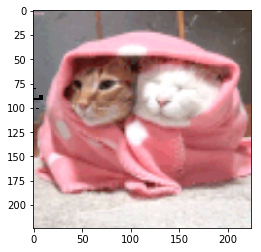

In [39]:
img = Image.fromarray(frame1_resized, 'RGB')
plt.imshow(img)

In [95]:
batch = np.expand_dims(frame1_resized, 0)
vgg16.predict(batch).shape

(1, 1000)

In [102]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [103]:
vgg16.layers.pop() # Get rid of the classification layer
vgg16.outputs = [vgg16.layers[-1].output]
vgg16.layers[-1].outbound_nodes = []

In [104]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [105]:
for layer in vgg16.layers: layer.trainable=False

In [106]:
vgg16.predict(batch).shape

(1, 4096)